# Project

# Introduction

## Contributions

## Table of Contents

## Dataset

# Setup of Environment

In [172]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd
import datetime as dt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn import metrics

ImportError: cannot import name 'rmse' from 'sklearn.metrics' (c:\Users\Yohannes\Documents\School\Master\DAT540_Group_11\venv\lib\site-packages\sklearn\metrics\__init__.py)

## Extract the data

In [3]:
plant_1_gen = pd.read_csv("Plant_1_Generation_data.csv")
plant_2_gen = pd.read_csv("Plant_2_Generation_data.csv")
plant_1_wea = pd.read_csv("Plant_1_Weather_Sensor_data.csv")
plant_2_wea = pd.read_csv("Plant_2_Weather_Sensor_data.csv")

# Data Exploration

## Check columns for missing values


### Plant 1

In [4]:
plant1_info = plant_1_gen.isnull().sum()
print(plant1_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [5]:
plant1_wea = plant_1_wea.isnull().sum()
print(plant1_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


### Plant 2

In [10]:
plant2_info = plant_2_gen.isnull().sum()
print(plant2_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


### Weather 2

In [11]:
plant2_wea = plant_2_wea.isnull().sum()
print(plant2_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [12]:
plant1_info = plant_1_gen.isnull().sum()
print(plant1_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


## How many sensors are at each plant?

In [13]:
print("Plant 1 has",plant_1_gen['SOURCE_KEY'].nunique(),"sensors")
print("Plant 2 has",plant_2_gen['SOURCE_KEY'].nunique(),"sensors")

Plant 1 has 22 sensors
Plant 2 has 22 sensors


<AxesSubplot:xlabel='DATE_TIME', ylabel='DATE_TIME'>

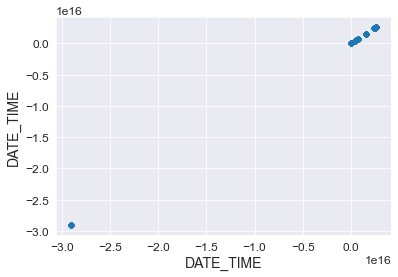

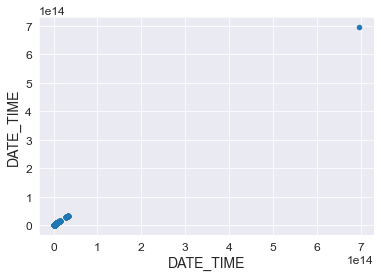

In [138]:
#Data for 34 days and continuous dates
numb_daws = pd.to_datetime(plant_1_gen['DATE_TIME']).dt.date.unique()

plant_1_gen['DATE_TIME'] = pd.to_datetime(plant_1_gen['DATE_TIME'])

data = plant_1_gen.groupby(['SOURCE_KEY']).apply(lambda x: x.sort_values(by=['DATE_TIME'], ascending=True))

time_gaps = pd.DataFrame(data.DATE_TIME.iloc[1:].diff())
non_continuous_dates = time_gaps.loc[(time_gaps.DATE_TIME.dt.seconds > 15*60) | (time_gaps.DATE_TIME.dt.seconds < -15*60)]
non_continuous_dates.index.set_names(["SOURCE_KEY", "Index"], inplace=True)

# non_continuous_dates.index.get_level_values(1)

# plot the non-continuous dates to visualize time gaps. Use the multiindex to identify the sensors and the index of the time gaps

# fill NaT values with 15 min timedelta, in non_continuous_dates
non_continuous_dates.fillna(pd.Timedelta(15*60, unit='s'), inplace=True)

time_gaps.plot(x='DATE_TIME', y='DATE_TIME', kind='scatter')
non_continuous_dates.plot(x='DATE_TIME', y='DATE_TIME', kind='scatter')


#### Some inverters have more data points then the others

In [ ]:
#Inverterids
print("Plant 1 statistics \n", plant_1_gen.SOURCE_KEY.value_counts())
print("Plant 2 statistics \n", plant_2_gen.SOURCE_KEY.value_counts())

Plant 1 statistics 
 bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ih0vzX44oOqAx2f    3130
ZnxXDlPa8U1GXgE    3130
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
iCRJl6heRkivqQ3    3125
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
zVJPv84UY57bAof    3124
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
1IF53ai7Xc0U56Y    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64
Plant 2 statistics 
 vOuJvMaM2sgwLmb    3259
PeE6FRyGXUgsRhN    3259
WcxssY2VbP4hApt    3259
LlT2YUhhzqhg5Sw    3259
xoJJ8DcxJEcupym    3259
LYwnQax7tkwH5Cb    3259
oZZkBaNadn6DNKz    3259
rrq4fwE8jgrTyWY    3259
9kRcWv60rDACzjR    3259
V94E5Ben1TlhnDV    3259
q49J1IKaHRwDQnt    3259
81aHJ1q11NBPMrL    3259
oZ35aAeoifZaQzV    3195
Mx2yZCDsyf6DPfv    3195
Et9kgGMDl729KT4    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6

## Data visualization

### **Convert datetime column to datetime format**

In [15]:
#Plant 1 weather data
plant_1_wea['DATE_TIME'] = pd.to_datetime(plant_1_wea['DATE_TIME']) 
plant_1_wea['TIME'] = plant_1_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_1_wea['DATE'] = pd.to_datetime(plant_1_wea['DATE_TIME'].dt.date)
print(plant_1_wea['DATE'])

#Plant 2 weather data
plant_2_wea['DATE_TIME'] = pd.to_datetime(plant_2_wea['DATE_TIME']) 
plant_2_wea['TIME'] = plant_2_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_2_wea['DATE'] = pd.to_datetime(plant_2_wea['DATE_TIME'].dt.date)


0      2020-05-15
1      2020-05-15
2      2020-05-15
3      2020-05-15
4      2020-05-15
          ...    
3177   2020-06-17
3178   2020-06-17
3179   2020-06-17
3180   2020-06-17
3181   2020-06-17
Name: DATE, Length: 3182, dtype: datetime64[ns]


### **Analysis of weather dataset for both the plants**

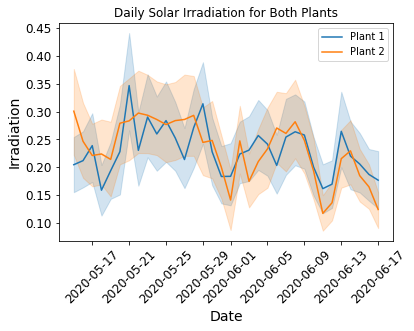

Mean of solar irradition from Plant1 0.22831283006565126
Mean of solar irradition from Plant2 0.23273697972872914


In [16]:
# Comparing both plants
# Daily Irradiation
ambient_compare = sns.lineplot(x='DATE', y='IRRADIATION', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='IRRADIATION', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambient_compare)
plt.ylabel('Irradiation')
plt.xlabel('Date')
plt.title('Daily Solar Irradiation for Both Plants')
plt.xticks(rotation=45)
plt.show()

# The mean of solar Irradiation for both plants are similar
mean_irradiationplant1 = plant_1_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant1', mean_irradiationplant1)
mean_irradiationplant2 =  plant_2_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant2', mean_irradiationplant2)

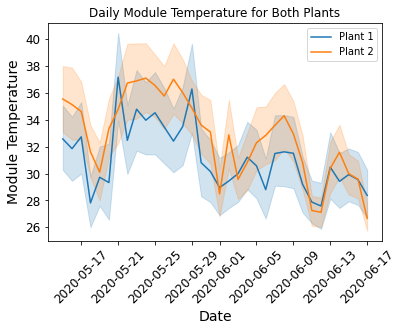

Mean of Module Temperature from Plant1 31.091015378426377
Mean of Module Temperature from Plant2 32.77240792902497


In [23]:
# Daily Module Temperature
modtemp_compare = sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=modtemp_compare)
plt.ylabel('Module Temperature')
plt.xlabel('Date')
plt.title('Daily Module Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()

# The mean of Module Temperature for both plants (Plant 1 is lower then Plant 2)
mean_moduletempplant1 = plant_1_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant1', mean_moduletempplant1)
mean_moduletempplant2 =  plant_2_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant2', mean_moduletempplant2)


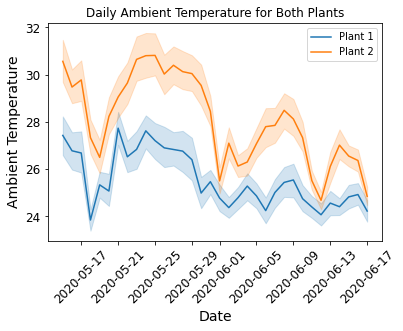

Mean of Ambient Temperature from Plant1 25.53160571756439
Mean of Ambient Temperature from Plant2 28.069399882321143


In [24]:
ambtemp_compare = sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambtemp_compare)
plt.ylabel('Ambient Temperature')
plt.xlabel('Date')
plt.title('Daily Ambient Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()


# The mean of Ambient Temperature for both plants (Plant 1 is lower then Plant 2)
mean_ambienttempplant1 = plant_1_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Ambient Temperature from Plant1', mean_ambienttempplant1)
mean_ambienttempplant2 =  plant_2_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Ambient Temperature from Plant2', mean_ambienttempplant2)

#### Observations

1. The mean solar irradiation values for both plants are similar.
2. The mean module temperature of Plant 1 is  lower than Plant 2 most of the time.
3. The mean ambient temperature of Plant 1 is much lower than Plant 2.


## Data cleaning


#### Transform and merge the datasets

##### Drop unwanted columns.

In [17]:
df_weather1 = plant_1_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant1 = plant_1_gen.drop(['PLANT_ID'], axis=1)
df_weather2 = plant_2_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant2 = plant_2_gen.drop(['PLANT_ID'], axis=1)

In [18]:
df_plant1["Human_key"] = df_plant1["SOURCE_KEY"].map({val: f"S{i:02d}" for i, val in enumerate(df_plant1["SOURCE_KEY"].unique())})
df_plant1.sample(20)

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,Human_key
43761,06-06-2020 02:30,7JYdWkrLSPkdwr4,0.000000,0.000000,0.000000,7764140.000,S03
44682,06-06-2020 13:00,1BY6WEcLGh8j5v7,11839.571430,1154.785714,4045.714286,6416587.714,S00
49927,09-06-2020 01:15,7JYdWkrLSPkdwr4,0.000000,0.000000,0.000000,7786793.000,S03
35958,02-06-2020 08:15,ZnxXDlPa8U1GXgE,8755.375000,856.637500,457.625000,6655900.625,S07
37196,02-06-2020 22:30,sjndEbLyjtCKgGv,0.000000,0.000000,7439.000000,7155447.000,S15
66442,16-06-2020 20:45,wCURE6d3bPkepu2,0.000000,0.000000,6274.000000,7022718.000,S17
27169,28-05-2020 19:45,YxYtjZvoooNbGkE,0.000000,0.000000,8375.000000,7284404.000,S21
13407,22-05-2020 03:00,1IF53ai7Xc0U56Y,0.000000,0.000000,0.000000,6233247.000,S01
50788,09-06-2020 11:00,WRmjgnKYAwPKWDb,11411.125000,1113.275000,2901.375000,7215902.375,S06
1812,15-05-2020 21:30,iCRJl6heRkivqQ3,0.000000,0.000000,6418.000000,7184410.000,S11


In [19]:
#Formatedattime
df_plant1['DATE_TIME']= pd.to_datetime(df_plant1['DATE_TIME'],format='%d-%m-%Y %H:%M')
df_weather1['DATE_TIME']= pd.to_datetime(df_weather1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
#df_plant1.head()
df_plant2['DATE_TIME']= pd.to_datetime(df_plant2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
df_weather2['DATE_TIME']= pd.to_datetime(df_weather2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

In [20]:
df_plant_weather1 = df_plant1.merge(df_weather1, left_on='DATE_TIME', right_on='DATE_TIME')
df_plant_weather2 = df_plant2.merge(df_weather2, left_on='DATE_TIME', right_on='DATE_TIME')

print(df_plant_weather1.head())
print(df_plant_weather2.head())

   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD  \
0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0   
1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0   
2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0   
3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0   
4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0   

  Human_key  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION      TIME  \
0       S00            25.184316           22.857507          0.0  00:00:00   
1       S01            25.184316           22.857507          0.0  00:00:00   
2       S02            25.184316           22.857507          0.0  00:00:00   
3       S03            25.184316           22.857507          0.0  00:00:00   
4       S04            25.184316           22.857507          0.0  00:00:00   

        DATE  
0 2020-05-15  
1 2020-05-15  
2 202

### Imputation

## Data Analysis

### **Data Correlation Analysis**


Observations:
1. High correlation between DC Power and AC power generation
2. High correlation between DC Power and IRRADIATION
3. Strong correlation between DC Power, AC Power and Module Temperature and Ambient Temperature

In [21]:
corr_matrix = df_plant_weather1.corr()

corr_matrix["DC_POWER"].sort_values(ascending=False)

DC_POWER               1.000000
AC_POWER               0.999996
IRRADIATION            0.989391
MODULE_TEMPERATURE     0.954811
AMBIENT_TEMPERATURE    0.724668
DAILY_YIELD            0.082243
TOTAL_YIELD            0.003851
Name: DC_POWER, dtype: float64

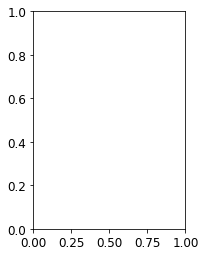

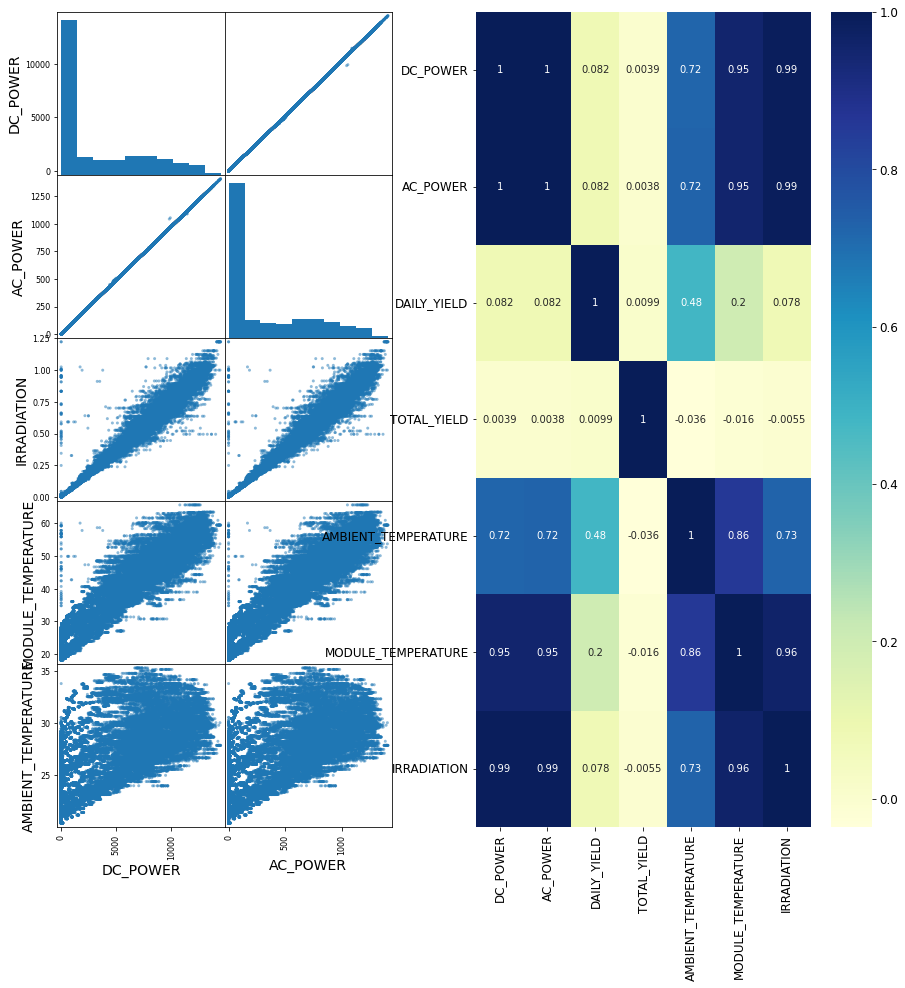

In [22]:
attributes = ["DC_POWER", "AC_POWER", "IRRADIATION",
              "MODULE_TEMPERATURE","AMBIENT_TEMPERATURE"]

plt.subplot(1, 2, 1)
scatter_plot = scatter_matrix(df_plant_weather1[attributes], figsize=(15, 15))

plt.subplot(1, 2, 2)
fig_corr = sns.heatmap(corr_matrix,cmap="YlGnBu", annot=True) # TODO - subplot + margin

**Analysis of DC power generated from each Source Keys.**
1. TheDistribution DC power generation plot shows multiple occasion where power generated was zero during daytime.
2.  plot of solar irradiation exhibits that the solar radiation never dropped to a lower value at day time. 
3. Analysis shows some inverters received no DC power even through there was enough sunlight
4. It could be concluded that the DC power generated and solar irradiation has a linear relationship.

### **Stacked Visualization of Power Generation**

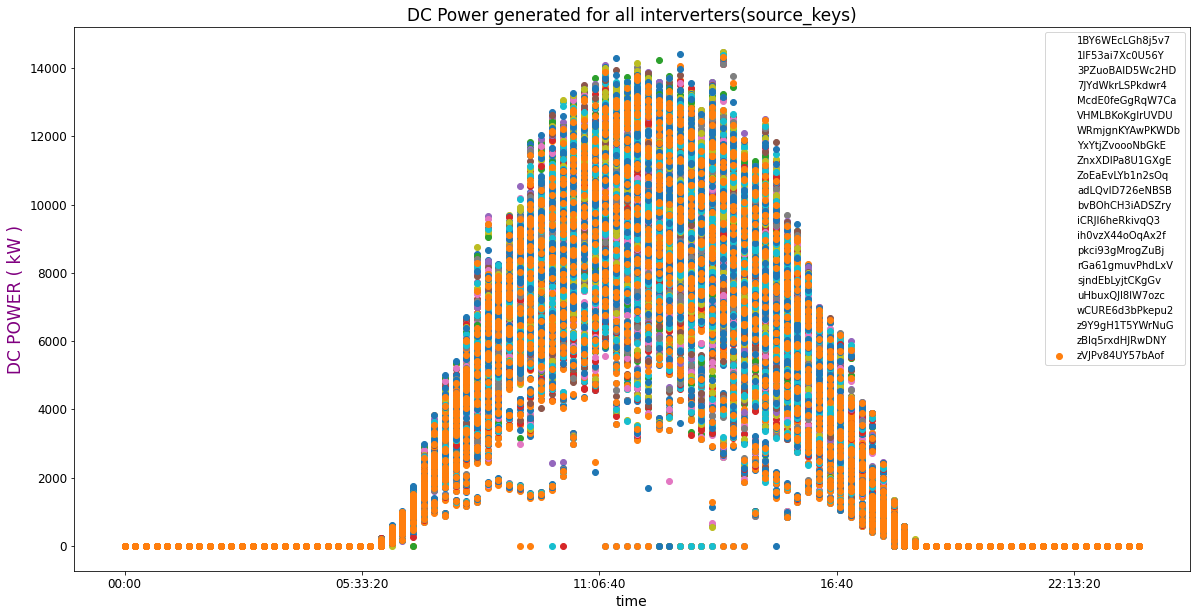

In [16]:
#DC power generated from each source keys
sources=df_plant_weather1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources.set_index('time').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power generated for all interverters(source_keys)',size=17)
plt.ylabel('DC POWER ( kW )',color='purple',fontsize=17)
plt.show()

                        mean  min          max      median       SOURCE_KEY  \
SOURCE_KEY                                                                    
1BY6WEcLGh8j5v7  2873.720981  0.0  13335.14286  302.955357  1BY6WEcLGh8j5v7   
1IF53ai7Xc0U56Y  3225.125523  0.0  14302.71429  450.526786  1IF53ai7Xc0U56Y   
3PZuoBAID5Wc2HD  3221.015673  0.0  14351.12500  456.160714  3PZuoBAID5Wc2HD   
7JYdWkrLSPkdwr4  3132.891955  0.0  14204.00000  438.571429  7JYdWkrLSPkdwr4   
McdE0feGgRqW7Ca  3211.307245  0.0  14418.42857  439.571429  McdE0feGgRqW7Ca   

                   mean_new  
SOURCE_KEY                   
1BY6WEcLGh8j5v7 -273.745332  
1IF53ai7Xc0U56Y   77.659209  
3PZuoBAID5Wc2HD   73.549359  
7JYdWkrLSPkdwr4  -14.574358  
McdE0feGgRqW7Ca   63.840931  


<AxesSubplot:xlabel='SOURCE_KEY'>

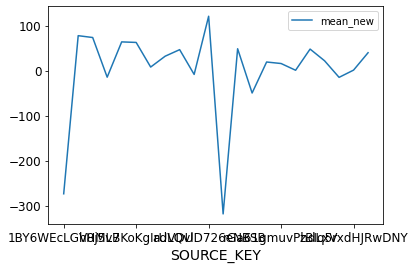

In [13]:
#Inverters with lower performace then rest "1BY6WEcLGh8j5v7", "bvBOhCH3iADSZry"
SOURCE = df_plant_weather1.groupby('SOURCE_KEY').agg({'DC_POWER': ['mean', 'min', 'max','median']})['DC_POWER']
SOURCE["SOURCE_KEY"] = SOURCE.index
mean = SOURCE['mean'].mean()
SOURCE["mean_new"] = SOURCE['mean'] - mean
print(SOURCE.head())

SOURCE.plot(x="SOURCE_KEY", y="mean_new")

## Research

Solar power plants generate a vast amount of data which can be used to determine how a plant is performing and what is impacting its performance. Taking this a step further, a plant’s performance can be optimized by leveraging advanced analytics. Advanced analytics includes formulating statistical matrices, implementing actionable performance alarms, and conducting artificial intelligent models to predict future performance. A relatively accurate energy prediction can be calculated by incorporating weather forecasts, a plant’s historical performance
This method requires substantial computing power and considerable time to develop accurate predictions. To illustrate this, this project will attempt to analyze power generation data in tandem with weather data to predict near-future (days) performance with data gathered from two solar power plants in India over a 34-day period.


### Select features of interest / Problem Statement

Prediction of power generation in coming days using different ML techniques

### Choose an appropriate ML model based on the dataset and your problem statement.

# ML Techniques


### Scoring Function

In [ ]:
def scoring(y_test, y_pred):
    R2_train = r2_score(y_test, y_pred)
    mse_train = mean_squared_error(y1_train, Y1_pred_train)
    rmse_train = np.sqrt(mse_train)
    return(R2_train, mse_train, rmse_train)

Linear Regression
From the data analysis and corerelation analsysis it was inferred that there is a linear relation between the DC power generated andthe solar irradiation. This relation can be modeled using a simple linear relationship as below,
𝑃(𝑡) = 𝑎 + 𝑏 . 𝐸(𝑡) where p(t) denotes the power generated and the E(t) denotes the solar irradiation. So we will run a linear regression model on our datasets.

### Model 1: Linear Regression for Plant 1 dataset

In [23]:
X1=df_plant_weather1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features 
y1=df_plant_weather1['DC_POWER'] # independent var / predictor

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X1_train.shape)
print("Y Train Shape = ",y1_train.shape)
print("X Test Shape  = ",X1_test.shape)
print("Y Test Shape  = ",y1_test.shape)

Shape of each Dataset : 
X Train Shape =  (55019, 2)
Y Train Shape =  (55019,)
X Test Shape  =  (13755, 2)
Y Test Shape  =  (13755,)


In [24]:
lm = LinearRegression()

Fit on training data

In [25]:
lm.fit(X1_train, y1_train)
lm.intercept_, lm.coef_

(920.6248402170099, array([-413.9842869 ,  409.91249727]))

In [17]:
print ('Plant 1 linear regression cofficients are:', X1.columns, lm.coef_ )
print('Plant 1 intercept', lm.intercept_)

Plant 1 linear regression cofficients are: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], dtype='object') [-413.9842869   409.91249727]
Plant 1 intercept 920.6248402170099


Prediction from model

In [160]:
Prediction_plant1 = lm.predict(X1_test)
Prediction_plant1
Y1_pred_train = lm.predict(X1_train)
Y1_pred_test = lm.predict(X1_test)

print ('Prediction Train dataset', Y1_pred_train)
print ('Prediction Train dataset', Y1_pred_test)

Prediction Train dataset [3265.78306504  -84.40620458  -94.70657481 ... -229.87289415   44.48001408
 6303.65079403]
Prediction Train dataset [10946.88674462   416.38905802   408.30946098 ...  -114.94126469
  -102.0006966   3509.02189614]


Actual Solar Output Values vs Predicted Values for Plant 1 using Linear Regression (This also includes faulty days dataset)

Text(0, 0.5, 'Actual Output')

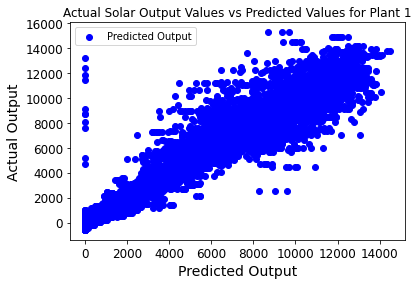

In [28]:
plt.scatter(y1_test, Y1_pred_test,color="b", label="Predicted Output")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

Model Evaluation for Linear Regression Model 1 using RMSE( Plant1 dataset)

In [20]:
print("Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)")
print("")
RMSE_train_1 = np.sqrt( metrics.mean_squared_error(y1_train, Y1_pred_train))
RMSE_test_1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
MAE1 = metrics.mean_absolute_error(y1_test, Y1_pred_test)
MSE1 = metrics.mean_squared_error(y1_test, Y1_pred_test)
RMSE1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
print('RMSE for training set = {}'.format(round(RMSE_train_1,2)))
print('RMSE for test set = {}'.format(round(RMSE_test_1,2)))
print('MAE: ', MAE1)
print('MSE: ',MSE1)

Model Evaluation for Linear Regression Model 1 using RMSE( Plant1)

RMSE for training set = 963.74
RMSE for test set = 951.48
MAE:  568.8351621419259
MSE:  905305.0591911231


### Model 1 : Linear Regression for Plant 2 dataset

In [165]:
X12=df_plant_weather2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE','IRRADIATION']] # Features 
y12=df_plant_weather2['DC_POWER'] # independent var / predictor

X12_train, X12_test, y12_train, y12_test = train_test_split(X12, y12, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X12_train.shape)
print("Y Train Shape = ",y12_train.shape)
print("X Test Shape  = ",X12_test.shape)
print("Y Test Shape  = ",y12_test.shape)

Shape of each Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


In [166]:
lm = LinearRegression()

Fit on training data for Plant 2

In [167]:

lm.fit(X12_train, y12_train)
lm.intercept_, lm.coef_

(-161.97807253891324, array([  14.58534235,   -7.47880945, 1066.65136632]))

Prediction from model

In [168]:
Prediction_plant2 = lm.predict(X12_test)
Prediction_plant2
Y12_pred_train = lm.predict(X12_train)
Y12_pred_test = lm.predict(X12_test)



print ('Prediction Train dataset', Y12_pred_train)
print ('Prediction Train dataset', Y12_pred_test)

scoring(y12_test, Prediction_plant2)

Prediction Train dataset [737.00239381  14.84125906 889.82726669 ... 913.38997752 447.33428339
 676.18815123]
Prediction Train dataset [682.54993805 500.27198931 741.65474769 ... 696.95868419  39.18080934
  25.96295897]
R2 for Train dataset: 0.6074875487162595   MSE for Train dataset: 929726.2691966918


Actual Solar Output Values vs Predicted Values for Plant 2 using Linear Regression (This also includes faulty days dataset)

Text(0, 0.5, 'Actual Output')

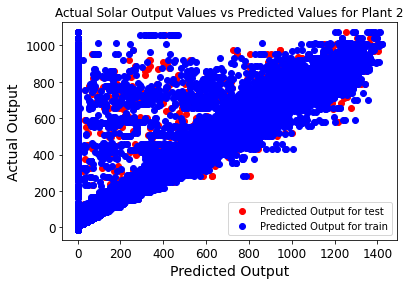

In [25]:
plt.scatter(y12_test, Y12_pred_test, color="r", label="Predicted Output for test")
plt.scatter(y12_train, Y12_pred_train, color="b", label="Predicted Output for train")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 2')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

Accuracy score for Plant 2 using Linear Regression

In [26]:
train_score_12 = lm.score(X12_train, y12_train)
test_score_12 = lm.score(X12_test, y12_test)

print("Model 1 Plant 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_12*100,0),"%")
print("Test Score  = ",round(test_score_12*100,0), "%")

Model 1 Plant 2 accuracy score: 

Train Score =  62.0 %
Test Score  =  61.0 %


### Model 2: Random Forest for Plant2 dataset 

Select columns that will be used to create train and test dataset

In [44]:
model_2 = df_plant_weather2
model_2.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
1,2020-05-15,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
2,2020-05-15,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,27.004764,25.060789,0.0,00:00:00,2020-05-15
3,2020-05-15,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,27.004764,25.060789,0.0,00:00:00,2020-05-15
4,2020-05-15,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,27.004764,25.060789,0.0,00:00:00,2020-05-15


In [45]:
X2 = model_2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']] # Features
y2 = model_2['DC_POWER'] # Target

X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.20, random_state=1, shuffle=False) 

print("Shape of each New Dataset : ")
print("X Train Shape = ",X2_train.shape)
print("Y Train Shape = ",y2_train.shape)
print("X Test Shape  = ",X2_test.shape)
print("Y Test Shape  = ",y2_test.shape)

Shape of each New Dataset : 
X Train Shape =  (54158, 3)
Y Train Shape =  (54158,)
X Test Shape  =  (13540, 3)
Y Test Shape  =  (13540,)


In [46]:

RF = RandomForestRegressor()
RF.fit(X2_train, y2_train)

RandomForestRegressor()

In [47]:
y2_pred_train = RF.predict(X2_train)
y2_pred_test = RF.predict(X2_test)

Model Evaluation for Random Forest

In [48]:
print("Model Evaluation for Random Forest Model 2 using RMSE")

RMSE_train_2 = np.sqrt( metrics.mean_squared_error(y2_train, y2_pred_train))
RMSE_test_2 = np.sqrt(metrics.mean_squared_error(y2_test, y2_pred_test))
MSE_train_2 = ( metrics.mean_squared_error(y2_train, y2_pred_train))
print('RMSE for training set is {}'.format(round(RMSE_train_2,2)))
print('RMSE for test set is {}'.format(round(RMSE_test_2,2)))
print('MSE for train set is {}'.format(round(MSE_train_2,2)))

Model Evaluation for Random Forest Model 2 using RMSE
RMSE for training set is 213.51
RMSE for test set is 162.82
MSE for train set is 45585.07


Accuracy score for Model 2

In [49]:
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  70.0 %
Test Score  =  68.0 %


Actual Solar Output Values vs Predicted Values for Plant 2 using Random Forest Regresor (This also includes faulty days dataset)

Text(0, 0.5, 'Actual Output')

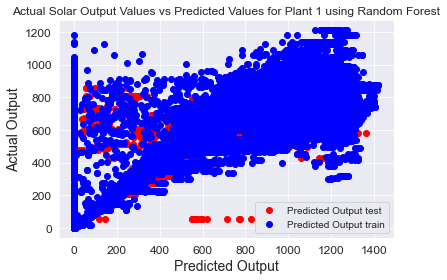

In [50]:
# This also includes faulty days dataset
plt.scatter(y2_test, y2_pred_test,color="r", label="Predicted Output test")
plt.scatter(y2_train, y2_pred_train,color="b", label="Predicted Output train")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1 using Random Forest')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

Feature Scaling

In [62]:
sc = StandardScaler()
X_train = sc.fit_transform(X2_train)
X_test = sc.transform(X2_test)

Running the model after Feature scaling

In [63]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X2_train, y2_train)
y3_pred = regressor.predict(X2_test)


Accuracy scorefor Model 2 after scaling data

In [51]:
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  70.0 %
Test Score  =  68.0 %


### Cross Validation

In [42]:
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

scores = cross_val_score(lm, X12, y12, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scores2 = cross_val_score(svm_reg, X12, y12, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores2.mean(), scores2.std()))

0.61 accuracy with a standard deviation of 0.09
0.48 accuracy with a standard deviation of 0.18


In [66]:
scores = cross_val_score(lm, X1, y1, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.94 accuracy with a standard deviation of 0.02


In [52]:

scores = cross_val_score(RF, X2_train, y2_train, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.63 accuracy with a standard deviation of 0.08


In [159]:
# import timeseriessplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def Cross_Validation(model, X, y, n_splits=10):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    scores = []
    for train_index, test_index in tscv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index] 

        model.fit(X_train, Y_train)
        predict = model.predict(X_test)

        scores.append(model.score(X_test, Y_test))
    
    return (np.mean(scores), np.std(scores))

lm = LinearRegression()
mean_score, std = Cross_Validation(lm, X12, y12)
print("%0.2f accuracy with a standard deviation of %0.2f" % (mean_score, std))

lm = LinearRegression()
mean_score, std = Cross_Validation(lm, X1, y1)
print("%0.2f accuracy with a standard deviation of %0.2f" % (mean_score, std))

rf = RandomForestRegressor()
mean_score, std = Cross_Validation(rf, X12, y12)
print("%0.2f accuracy with a standard deviation of %0.2f" % (mean_score, std))
    



0.60 accuracy with a standard deviation of 0.08
0.94 accuracy with a standard deviation of 0.02
0.63 accuracy with a standard deviation of 0.08



Tune the parameters of your model. 
Make predictions regarding the future values for some of your chosen variables. 

## Arima

# Installing all packages and importing files

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import datetime as dt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

In [3]:
gen_1=pd.read_csv('./Plant_2_Generation_Data.csv')
gen_1.drop('PLANT_ID',1,inplace=True)

gen_2=pd.read_csv('./Plant_1_Generation_Data.csv')
gen_2.drop('PLANT_ID',1,inplace=True)

sens_1= pd.read_csv('./Plant_2_Weather_Sensor_Data.csv')
sens_1.drop('PLANT_ID',1,inplace=True)
#format datetime
gen_1['DATE_TIME']= pd.to_datetime(gen_1['DATE_TIME'],format='%Y-%m-%d %H:%M') #named plant 2 data as gen_1
gen_2['DATE_TIME']= pd.to_datetime(gen_2['DATE_TIME'],format='%d-%m-%Y %H:%M') #named plant 1 data as gen_2
sens_1['DATE_TIME']= pd.to_datetime(sens_1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# Daily Yield & AC-DC power
This plot shows that plant 1 is only outputting barely 10% of expected inverted output. Massive human error involved. Data cannot be used

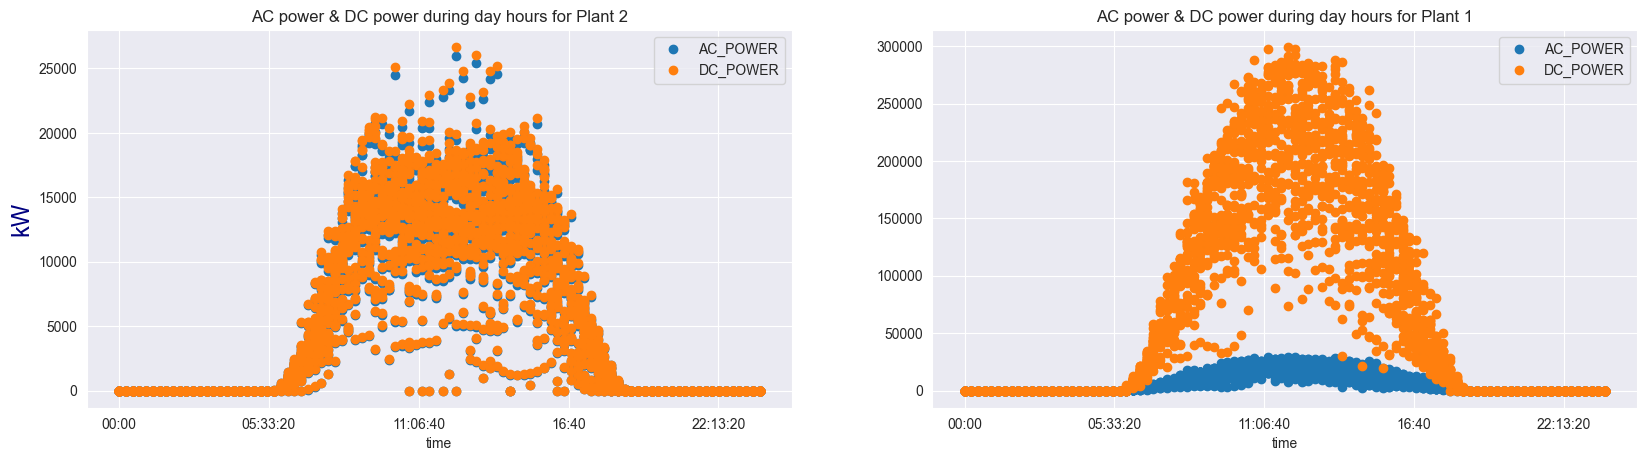

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
3100,2020-05-16 11:15:00,xMbIugepa2P7lBB,1231.357143,1200.571429,3447.428571,1.066695e+08
3101,2020-05-16 11:15:00,xoJJ8DcxJEcupym,0.000000,0.000000,1792.000000,2.091485e+08
3102,2020-05-16 11:30:00,4UPUqMRk7TRMgml,0.000000,0.000000,2525.000000,2.435737e+06
3103,2020-05-16 11:30:00,81aHJ1q11NBPMrL,928.700000,905.486667,3782.666667,1.215286e+09
3104,2020-05-16 11:30:00,9kRcWv60rDACzjR,1261.440000,1229.893333,3735.133333,2.247733e+09
3105,2020-05-16 11:30:00,Et9kgGMDl729KT4,1158.866667,1130.920000,2685.133333,1.711089e+06
3106,2020-05-16 11:30:00,IQ2d7wF4YD8zU1Q,1287.466667,1255.280000,3843.000000,1.995503e+07
3107,2020-05-16 11:30:00,LYwnQax7tkwH5Cb,0.000000,0.000000,1828.000000,1.794969e+09
3108,2020-05-16 11:30:00,LlT2YUhhzqhg5Sw,1265.833333,1234.193333,3697.666667,2.826057e+08
3109,2020-05-16 11:30:00,Mx2yZCDsyf6DPfv,0.000000,0.000000,2582.000000,2.464028e+06


In [5]:
df_gen=gen_1.groupby('DATE_TIME').sum().reset_index() #group all items by the increments, which has several inverters. SUm all the inverter values into one. SO you get one value per time step for each collumn
df_gen['time']=df_gen['DATE_TIME'].dt.time #taking the time component from datetime and making a collumn

#Setting up plant 2 dataframe
df_gen2=gen_2.groupby('DATE_TIME').sum().reset_index()
df_gen2['time']=df_gen2['DATE_TIME'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))

# daily yield plot
#df_gen.plot(x='DATE_TIME',y='DAILY_YIELD',color='navy',ax=ax[0])


# AC & DC power plot
df_gen.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[0]) #plant 2 plot
df_gen2.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[1]) #plant 1 plot


#ax[0].set_title('Daily yield',)


ax[0].set_title('AC power & DC power during day hours for Plant 2')
ax[1].set_title('AC power & DC power during day hours for Plant 1')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

pd.options.display.max_rows = 4000 #output text size
gen_1[3100:3120] #snapshot of plant 1 to illustrate this dataframe carries several inverters for each time step

# Illustrate that all inverter values have been added to total across each step

In [6]:
df_gen[115:135] 

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,time
115,2020-05-16 05:00:00,0.000000,0.000000,18561.000000,1.418976e+10,05:00:00
116,2020-05-16 05:15:00,0.000000,0.000000,18561.000000,1.418976e+10,05:15:00
117,2020-05-16 05:30:00,0.000000,0.000000,631.000000,1.407909e+10,05:30:00
118,2020-05-16 05:45:00,0.000000,0.000000,0.000000,1.418960e+10,05:45:00
119,2020-05-16 06:00:00,313.557619,302.671905,22.295238,1.418976e+10,06:00:00
120,2020-05-16 06:15:00,1032.840000,998.906667,179.800000,1.409562e+10,06:15:00
121,2020-05-16 06:30:00,1892.047619,1836.448571,533.347619,1.418976e+10,06:30:00
122,2020-05-16 06:45:00,2790.566667,2715.686667,1101.066667,1.418976e+10,06:45:00
123,2020-05-16 07:00:00,3700.975238,3625.843810,1899.504762,1.418976e+10,07:00:00
124,2020-05-16 07:15:00,5537.123333,5433.604762,2946.466667,1.418976e+10,07:15:00


# Why original DAILY_YIELD and TOTAL_YIELD is wrong

Source Data mentions that DAILY_YIELD is a cumulative sum of power generated on that day, till that point in time. Power is a running rate, it cannot be Cumulative. Source Data also mentions TOTAL_YIELD is the total yield for the inverter till that point in time. However, cumulative
calculations are not consistent and therefore unusable. 

A snapshot of 3 days will be shown for both. DAILY_YIELD frequenlty dips, even though it has the correct general shape. This cannot be as it is reasonably a calculated value and is CUMULATIVE. The flat lines of TOTAL_YIELD also indicates to clue that it is not a proper cumulative,
especially since DAILY_YIELD is regularly producing output. There is also dips here, which are not possible.

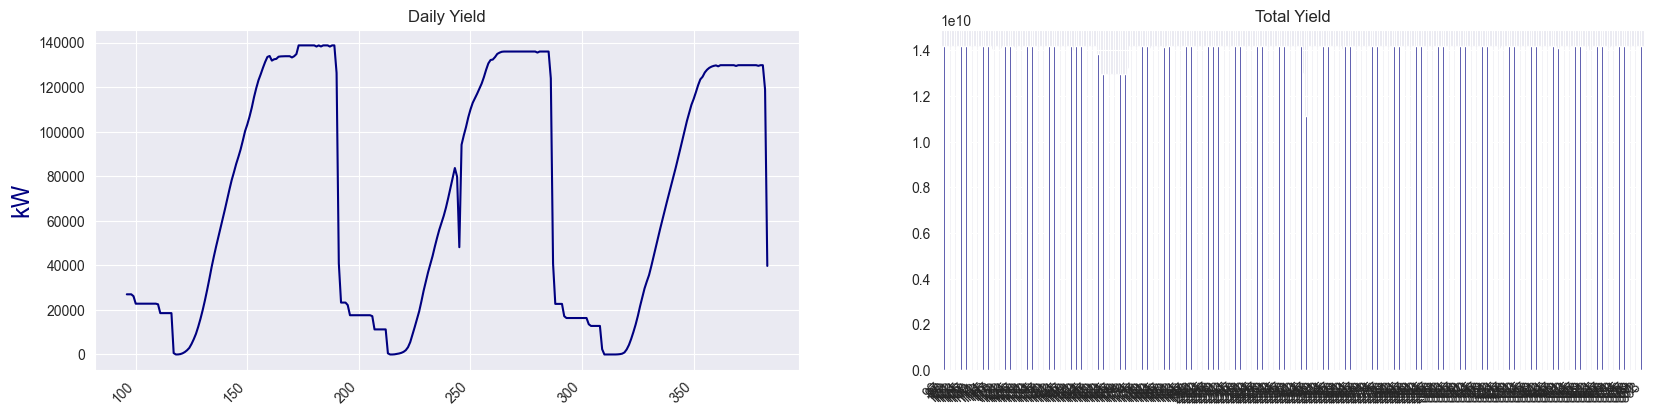

In [10]:
testDays = df_gen.loc[(df_gen['DATE_TIME'] > '2020-05-16') & (df_gen['DATE_TIME'] <= "2020-05-19")]


fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
testDays['DAILY_YIELD'].plot(ax=ax[0],color='navy') # DAILY_YIELD graph
testDays['TOTAL_YIELD'].plot(kind='bar',ax=ax[1],color='navy') #TOTAL_YIELD graph
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

#testDays

# Creating new and correct DAILY_YIELD and TOTAL_YIELD

In [11]:
new_df=df_gen.copy()
new_df = new_df.drop(['DAILY_YIELD','TOTAL_YIELD'], 1) #Dropping DAILY_YIELD & TOTAL_YIELD. UNUSABLE

new_df["NEW_YIELD"] = (new_df['AC_POWER'] * 0.25) #Energy generation during this step

new_df['date']=new_df['DATE_TIME'].dt.date #taking date component of datetime into a new collumn


new_df["DAILY_YIELD"] = new_df.groupby('date').NEW_YIELD.cumsum() 
new_df["TOTAL_YIELD"] = new_df.NEW_YIELD.cumsum() 


#testDays = new_df.loc[(new_df['DATE_TIME'] > '2020-05-16') & (new_df['DATE_TIME'] <= "2020-05-19")]
#new_df = new_df.drop(['DAILY_YIELD','TOTAL_YIELD'], 1)


#df_gen=gen_1.groupby('DATE_TIME').sum().reset_index() #group all items by the increments, which has several inverters. SUm all the inverter values into one. SO you get one value per time step for each collumn
#df_gen['time']=df_gen['DATE_TIME'].dt.time #taking the time component from datetime and making a collumn

new_df[110:130] #snapshot of new dataframe (single step)


,DATE_TIME,DC_POWER,AC_POWER,time,NEW_YIELD,date,DAILY_YIELD,TOTAL_YIELD
110,2020-05-16 03:45:00,0.000000,0.000000,03:45:00,0.000000,2020-05-16,0.000000,162859.434167
111,2020-05-16 04:00:00,0.000000,0.000000,04:00:00,0.000000,2020-05-16,0.000000,162859.434167
112,2020-05-16 04:15:00,0.000000,0.000000,04:15:00,0.000000,2020-05-16,0.000000,162859.434167
113,2020-05-16 04:30:00,0.000000,0.000000,04:30:00,0.000000,2020-05-16,0.000000,162859.434167
114,2020-05-16 04:45:00,0.000000,0.000000,04:45:00,0.000000,2020-05-16,0.000000,162859.434167
115,2020-05-16 05:00:00,0.000000,0.000000,05:00:00,0.000000,2020-05-16,0.000000,162859.434167
116,2020-05-16 05:15:00,0.000000,0.000000,05:15:00,0.000000,2020-05-16,0.000000,162859.434167
117,2020-05-16 05:30:00,0.000000,0.000000,05:30:00,0.000000,2020-05-16,0.000000,162859.434167
118,2020-05-16 05:45:00,0.000000,0.000000,05:45:00,0.000000,2020-05-16,0.000000,162859.434167
119,2020-05-16 06:00:00,313.557619,302.671905,06:00:00,75.667976,2020-05-16,75.667976,162935.102143


# Daily and Total Yield Plots
Replacing df_gen for easier carrydown

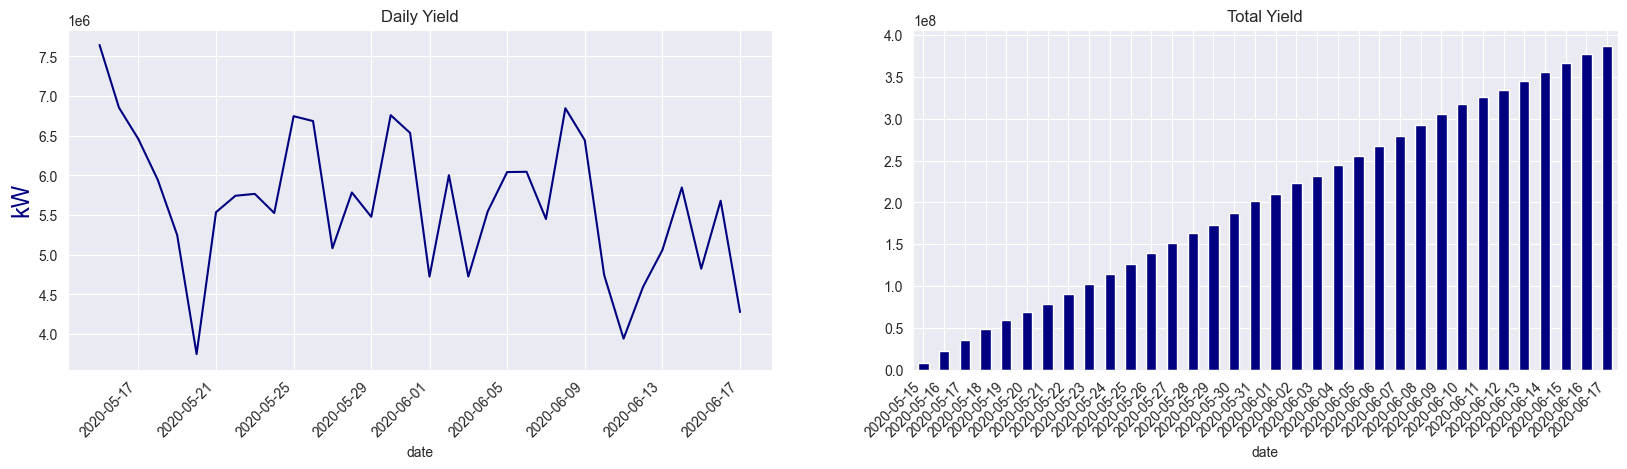

,DC_POWER,AC_POWER,NEW_YIELD,DAILY_YIELD,TOTAL_YIELD
date,,,,,
2020-05-15,666607.630952,651437.736667,162859.434167,7.645248e+06,7.645248e+06
2020-05-16,566839.840000,554253.460476,138563.365119,6.854685e+06,2.248919e+07
2020-05-17,556236.918205,544393.020916,136098.255229,6.457714e+06,3.539430e+07
2020-05-18,530773.677143,519012.565238,129753.141310,5.942708e+06,4.794473e+07
2020-05-19,443495.847015,433554.722647,108388.680662,5.245356e+06,5.913640e+07
2020-05-20,352374.378810,344661.406190,86165.351548,3.744291e+06,6.860793e+07
2020-05-21,494112.260000,483021.364286,120755.341071,5.534586e+06,7.867010e+07
2020-05-22,498711.327619,487411.941136,121852.985284,5.742565e+06,9.047059e+07
2020-05-23,501823.294762,490450.510476,122612.627619,5.766006e+06,1.021919e+08


In [12]:
df_gen = new_df #replacing df_gen for easier carrydown
daily_gen=df_gen.copy()
daily_gen['date']=daily_gen['DATE_TIME'].dt.date #taking date component of datetime into a new collumn

daily_gen=daily_gen.groupby('date').sum() #summing all the steps in a date so u get one value per date

fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
daily_gen['DAILY_YIELD'].plot(ax=ax[0],color='navy')
daily_gen['TOTAL_YIELD'].plot(kind='bar',ax=ax[1],color='navy')
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

daily_gen

# Task 2: Forecast
## Can we predict the power generation for next couple of days? 

Tune auto_arima function, a SEASONAL ARIMA(p,d,q) + (P,D,Q,m) model,on the last 4 days(384 observations) to see if our model can capture the last generation trend. 

In [13]:
from pandas.tseries.offsets import DateOffset
! pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


New fixed gen_1 Data

In [14]:
new_gen1=gen_1.copy()
new_gen1 = new_gen1.drop(['DAILY_YIELD','TOTAL_YIELD'], 1) #Dropping DAILY_YIELD & TOTAL_YIELD. UNUSABLE

new_gen1["NEW_YIELD"] = (new_gen1['AC_POWER'] * 0.25) #Energy generation during this step

new_gen1['date']=new_gen1['DATE_TIME'].dt.date #taking date component of datetime into a new collumn


new_gen1["DAILY_YIELD"] = new_gen1.groupby(['date', 'SOURCE_KEY']).NEW_YIELD.cumsum() 
new_gen1["TOTAL_YIELD"] = new_gen1.NEW_YIELD.cumsum() 

new_gen1 

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,NEW_YIELD,date,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4UPUqMRk7TRMgml,0.0,0.0,0.0,2020-05-15,0.000000,0.000000e+00
1,2020-05-15 00:00:00,81aHJ1q11NBPMrL,0.0,0.0,0.0,2020-05-15,0.000000,0.000000e+00
2,2020-05-15 00:00:00,9kRcWv60rDACzjR,0.0,0.0,0.0,2020-05-15,0.000000,0.000000e+00
3,2020-05-15 00:00:00,Et9kgGMDl729KT4,0.0,0.0,0.0,2020-05-15,0.000000,0.000000e+00
4,2020-05-15 00:00:00,IQ2d7wF4YD8zU1Q,0.0,0.0,0.0,2020-05-15,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...
67693,2020-06-17 23:45:00,q49J1IKaHRwDQnt,0.0,0.0,0.0,2020-06-17,4163.787024,4.083507e+06
67694,2020-06-17 23:45:00,rrq4fwE8jgrTyWY,0.0,0.0,0.0,2020-06-17,3937.229405,4.083507e+06
67695,2020-06-17 23:45:00,vOuJvMaM2sgwLmb,0.0,0.0,0.0,2020-06-17,4336.359405,4.083507e+06
67696,2020-06-17 23:45:00,xMbIugepa2P7lBB,0.0,0.0,0.0,2020-06-17,4215.096190,4.083507e+06


#### Our data:

In [15]:
pred_gen=new_gen1.copy()
pred_gen=pred_gen.groupby('DATE_TIME').sum()
pred_gen=pred_gen['DAILY_YIELD'][-288:].reset_index()
pred_gen.set_index('DATE_TIME',inplace=True)
pred_gen.head()

,DAILY_YIELD
DATE_TIME,
2020-06-15 00:00:00,0.0
2020-06-15 00:15:00,0.0
2020-06-15 00:30:00,0.0
2020-06-15 00:45:00,0.0
2020-06-15 01:00:00,0.0


## Step 1: Testing for Stationarity


* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

In [16]:
result = adfuller(pred_gen['DAILY_YIELD'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.802053465695508
p-value : 0.37944268253013164
#Lags Used : 0
Number of Observations Used : 287
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

## Step 2: Split into train and test datasets to build the model on the training dataset and forecast using the test dataset.

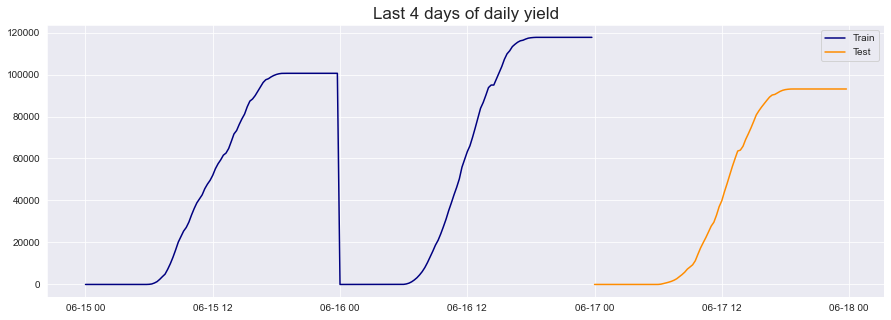

,DAILY_YIELD
DATE_TIME,
2020-06-15 00:00:00,0.000000
2020-06-15 00:15:00,0.000000
2020-06-15 00:30:00,0.000000
2020-06-15 00:45:00,0.000000
2020-06-15 01:00:00,0.000000
2020-06-15 01:15:00,0.000000
2020-06-15 01:30:00,0.000000
2020-06-15 01:45:00,0.000000
2020-06-15 02:00:00,0.000000


In [17]:
train=pred_gen[:192]
test=pred_gen[-96:]
plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of daily yield',fontsize=17)
plt.legend()
plt.show()

train

## Step 3: Tune with the auto_arima function:



`P` is  The order of the seasonal component for the auto-regressive (AR) model.

`D` is The integration order of the seasonal process.

`Q` is The order of the seasonal component of the moving average (MA) model.
P and Q and be estimated similarly to p and q via auto_arima, and D can be estimated via a Canova-Hansen test, however m generally requires subject matter knowledge of the data.

Since we know that our observations are recorded at 15 minute intervals, (so for each day we have 96 observations) we can choose `m` parameter equal to 96 to capture daily trend.
To speed up the parameters search, I fixed a max order of 1 for P,D,Q paramaters in the seasonal component. 

In [18]:
arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=1564.460, Time=1.79 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=inf, Time=17.97 sec
 ARIMA(0,1,1)(0,1,1)[96]             : AIC=1563.286, Time=18.79 sec
 ARIMA(0,1,1)(0,1,0)[96]             : AIC=1565.605, Time=6.70 sec
 ARIMA(0,1,1)(1,1,1)[96]             : AIC=1565.299, Time=20.15 sec
 ARIMA(0,1,1)(1,1,0)[96]             : AIC=1563.305, Time=16.65 sec
 ARIMA(0,1,0)(0,1,1)[96]             : AIC=1562.137, Time=8.83 sec
 ARIMA(0,1,0)(1,1,1)[96]             : AIC=1564.122, Time=19.23 sec
 ARIMA(0,1,0)(1,1,0)[96]             : AIC=1562.071, Time=18.55 sec
 ARIMA(1,1,1)(1,1,0)[96]             : AIC=1568.909, Time=46.40 sec
 ARIMA(0,1,0)(1,1,0)[96] intercept   : AIC=1563.417, Time=24.14 sec

Best model:  ARIMA(0,1,0)(1,1,0)[96]          
Total fit time: 199.573 seconds


## Step 4: Use the trained model which was built earlier to forecast daily yields

We use the trained model to forecast the last 96 observations of the test data, 17th June daily yield,  and then we will forecast daily yield for 18th and 19th June.

In [19]:
future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

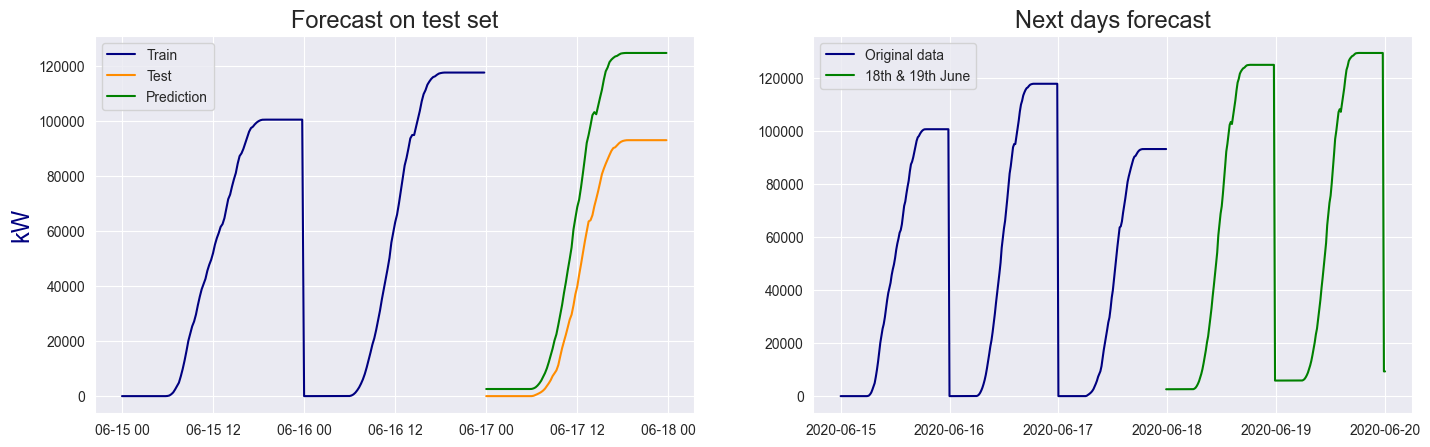

In [20]:
prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set',size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)


f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(pred_gen,label='Original data',color='navy')
ax[1].plot(f_prediction,label='18th & 19th June',color='green')
ax[1].legend()
ax[1].set_title('Next days forecast',size=17)
plt.show()

## Model summary:

In [21]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 96)   Log Likelihood                -779.036
Date:                            Sat, 27 Nov 2021   AIC                           1562.071
Time:                                    13:25:52   BIC                           1567.179
Sample:                                         0   HQIC                          1564.135
                                            - 192                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L96       0.2652      0.091      2.924      0.003       0.087       0.443
sigma2      7.454e+05   6.79e+04     10.983      0.000    6.12e+05    8.78e+05
===================================================================================
Ljung-Box (L1) (Q):                  29.74   Jarque-Bera (JB):               111.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.89
Prob(H) (two-sided):                  0.05   Kurtosis:                         8.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 Evaluate your model based on different metrics. 

 - R2, 
 - MSE,
 - RSME,
 - Cross validation

# References